# Rasterizing AIS data

### Purpose
Shipboard location information is emitted from Automatic Identification System (AIS) transmitters on vessels over a certain size. AIS data includes information such as ship type, name, position, course and speed. This notebook loads AIS data stored as CSVs and generates projected vessel traffic density grids.

### Inputs
This notebook uses AIS data provided by the [Marine Exchange of Alaska](http://www.mxak.org/vtrack/vtrack_intro.html). This data is made available to the Research Workspace as a Data Asset, so the files can be read as if they were on a local file system.

### Outputs
We write the resulting grid out as a netCDF file, and map the grid to produce an image saved to the workspace.

### Modification History
2018-03-08: Original development (John Marc Dunaway, Axiom)  
2018-04-10: Script moved into the Research Workspace (W. Koeppen, Axiom)  
2018-04-13: Cleaned up syntax, added plotting, added documentation   
2018-05-21: Rasterizing with large cell size for particle release regridding (J. Lopez)

In [1]:
import datetime
import os
import glob
import pandas as pd
import geopandas as gpd

import shapely.wkt

import rasterio
from rasterio.features import rasterize
#from rasterio.enums import MergeAlg
import numpy as np
import cartopy

from tqdm import trange

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import distributed

In [2]:
daskc = distributed.Client('aracuaria.ib.axiomptk:8786')
daskc

Client Scheduler: tcp://aracuaria.ib.axiomptk:8786 Dashboard: http://aracuaria.ib.axiomptk:8787/status,Cluster Workers: 28 Cores: 168 Memory: 710.42 GB


# AIS Data Sources
The Marine Cadastre dataset includes data from all of the US. For this work, we can use the Marine Exchange dataset, which is just Alaska-based AIS data. The Marine Exchange of Alaska gave all their data to the Marine Cadastre, so it should be a duplicate in this region. This data covers 2013-2017.

In [3]:
outdir = '../../outputs/OSRA/rpg-by-shiptype-bymonth/'
outbase = 'akmx-rpg'

# dataset='marine_cadastre'
dataset = 'marine_exchange'
year = '*'
month = '*'
day = '*'
filelike = year + '-' + month + '-' + day + '*.csv'

In [4]:
# gets a dataframe for all the files in a dir
path =r'/data/assets/ais/voyages/csvs/'+dataset+'/'
allfiles = glob.glob(path +year+ "/*"+filelike)

In [5]:
print(len(allfiles), 'files')

1826 files


# Set up the output grid
The bounds and resolution of the output. AIS data in the Asset catalog are stored in [EPSG:4326](http://spatialreference.org/ref/epsg/wgs-84/), which is the most common projection for satellite navigation systems. However, it's not the best for comparing ship densities at northern latitudes because the size of the grid cells can vary dramatically from the Aleutians to Barrow. So we output our grids in Alaska Albers [EPSG:3338](http://spatialreference.org/ref/epsg/nad83-alaska-albers/).

In [6]:
#raster resolution in meters
pixel_size=10000

#bounds of output grid in lat/lon
output_min_lon = -168
output_max_lon = -141
output_min_lat = 69
output_max_lat = 73

# Lat/Lon CRS
in_crs = {'init': 'epsg:4326'}

# Equal area projection
out_crs={'init': 'epsg:3338'}

In [7]:
# convert the bounding box to our output projection
bounding_box = shapely.geometry.box(output_min_lon, output_min_lat, output_max_lon, output_max_lat)
bbDF = gpd.GeoDataFrame(crs=in_crs,geometry=[bounding_box])
bbDF = bbDF.to_crs(out_crs)

In [8]:
x_min, y_min, x_max, y_max = bbDF.iloc[0].geometry.bounds
x_res = int((x_max - x_min) / pixel_size)
y_res = int((y_max - y_min) / pixel_size)
print('Output dimensions: ' + str(x_res) + ' x ' + str(y_res))

Output dimensions: 108 x 43


In [9]:
x_min, y_min, x_max, y_max

(-562708.9066016661, 2166223.253386663, 523050.2906071187, 2600636.9438454816)

GDAL uses an affine matrix to translate from world coordinates to pixel coordinates. Unfortunately GDAL transforms are difficult to impossible to find documentation about, so we use the abstracted library of rasterio, which is itself undocumented.

In [10]:
# west, north, xsize, ysize
raster_transform = rasterio.transform.from_origin(x_min, y_max, pixel_size, pixel_size)

In [11]:
# lon = np.linspace(min_lon, max_lon, (max_lon-min_lon) * resolution) # 200 points/degree = .005 degee resolution
# lat = np.linspace(min_lat, max_lat, (max_lat-min_lat) * resolution)

## Read files and create GeoDataFrame
The status of the Dask cluster can be accessed at: http://10.2.10.2:8787/status

In [12]:
#Function to turn a CSV into a subsetted and transformed geodataframe
def read_file_to_gdf(file) :
    df = pd.read_csv(file, index_col=None, header=0)
    
    geometry = df['WKT'].map(shapely.wkt.loads)
    
    gdf = gpd.GeoDataFrame(df.drop(['lat', 'lon', 'WKT'], axis=1),
                           crs=in_crs, geometry=geometry)
    gdf = gdf.to_crs(out_crs)

    # Clip to bounding box
    gdf = gdf[gdf['geometry'].intersects(bbDF['geometry'].iloc[0])]
    
    return gdf

In [13]:
# non-dask way to get a dataframe for all the files in a dir
# gdf = GeoDataFrame()
# for i in trange(len(allfiles)):
#    file_=allfiles[i]
#    gdf =gdf.append(read_file_to_gdf(file_))
# gdf['value']=1

In [14]:
futures = daskc.map(read_file_to_gdf, allfiles)
total=daskc.gather(futures)

gdf = pd.concat(total)

gdf.to_csv(outdir + outbase + '-allyears-' + 'gdf.csv')

print(len(gdf), 'shapes in output area')
print(len(gdf['mmsi'].drop_duplicates()), 'unique vessels')

31101 shapes in output area
256 unique vessels


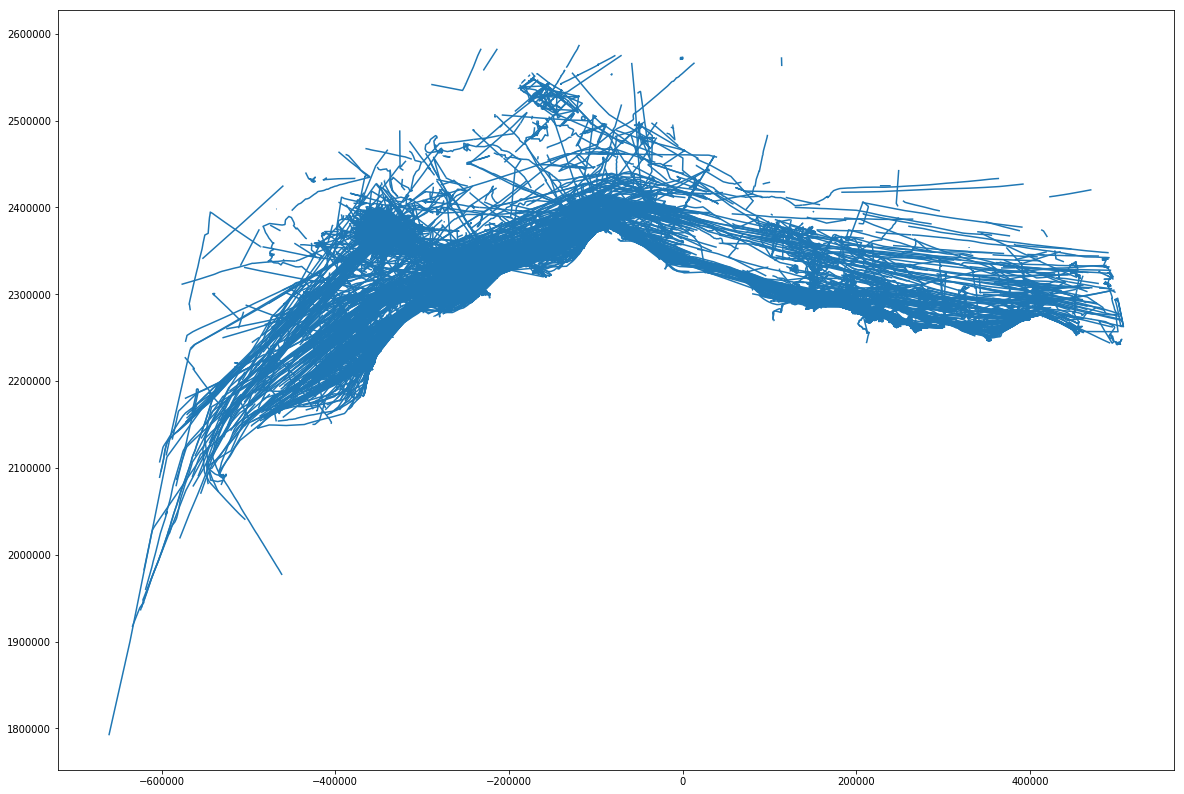

In [15]:
#Let's See It!
gdf.plot(figsize=(20, 20))
plt.show()

# Separate by archtype

In [16]:
# Merge in ship types
ship_catalog = pd.read_csv('../../data/ais/avis_ship_catalog_scrambled.csv', index_col='scrambled_mmsi')
track_catalog = gdf.merge(ship_catalog, left_on='mmsi', right_index=True)

In [17]:
# Merge in grouped types (and fuel capacities)
fuel_capacity = pd.read_csv('../../data/ship-details/fuel-capacity-by-type.csv', index_col='type')
track_catalog = track_catalog.merge(fuel_capacity, left_on='type', right_index=True)

# I'm replacing the group and don't want to get confused by this one
track_catalog.drop(columns=['groupped_type'])

,mmsi,timestamp,geometry,type,draught,beam,length,count,mean length (m),max length (m),mean length (ft),minimum (gallons),maximum (gallons),fuel capacity archtype,grouped_type
46,TKAEUVVOU,1507325851,LINESTRING (157102.3128897185 2285418.56864132...,Towing,0.0,0.0,0.0,2828,45.359972,109.0,149,50000.0,120000.0,Harbor/Ocean Tug,Tugboat
447,TKAEUVVOU,1501469322,"LINESTRING (145711.81133901 2286266.96838296, ...",Towing,0.0,0.0,0.0,2828,45.359972,109.0,149,50000.0,120000.0,Harbor/Ocean Tug,Tugboat
448,TKAEUVVOU,1501519193,LINESTRING (158225.9238316352 2285917.03110537...,Towing,0.0,0.0,0.0,2828,45.359972,109.0,149,50000.0,120000.0,Harbor/Ocean Tug,Tugboat
449,TKAEUVVOU,1501520572,LINESTRING (158223.9758898085 2285911.05551454...,Towing,0.0,0.0,0.0,2828,45.359972,109.0,149,50000.0,120000.0,Harbor/Ocean Tug,Tugboat
479,TKAEUVVOU,1504497553,LINESTRING (142446.5868638895 2283761.44713064...,Towing,0.0,0.0,0.0,2828,45.359972,109.0,149,50000.0,120000.0,Harbor/Ocean Tug,Tugboat
480,TKAEUVVOU,1504548663,LINESTRING (143094.932631114 2284395.014881579...,Towing,0.0,0.0,0.0,2828,45.359972,109.0,149,50000.0,120000.0,Harbor/Ocean Tug,Tugboat
97,TKAEUVVOU,1506192029,LINESTRING (157502.4454188343 2285615.81043616...,Towing,0.0,0.0,0.0,2828,45.359972,109.0,149,50000.0,120000.0,Harbor/Ocean Tug,Tugboat
266,TKAEUVVOU,1504891806,LINESTRING (157799.8961522332 2285698.81589667...,Towing,0.0,0.0,0.0,2828,45.359972,109.0,149,50000.0,120000.0,Harbor/Ocean Tug,Tugboat
324,TKAEUVVOU,1502072353,LINESTRING (144182.1152368186 2284365.87818126...,Towing,0.0,0.0,0.0,2828,45.359972,109.0,149,50000.0,120000.0,Harbor/Ocean Tug,Tugboat
325,TKAEUVVOU,1502090354,LINESTRING (157230.8072292457 2285463.37832044...,Towing,0.0,0.0,0.0,2828,45.359972,109.0,149,50000.0,120000.0,Harbor/Ocean Tug,Tugboat


In [18]:
ship_types = track_catalog['grouped_type'].unique()
ntypes =  len(ship_types)

for ship_type in ship_types:
    print(ship_type)

Tugboat
Ice Breaker
Landing
Cable Layer
Offshore Supply
Cargo
Pilot
Military
Tanker
Anti-Pollution
Utility
Public, Unclassified
Fishing
Survey
Sailing
Passenger
Search and Rescue
Buoy Layer
Recreational
Law enforcement
Industrial
Port Tender
Training
Drill Ship
Platform


# Burn Geometry and Write Raster
Rasterio does all the heavy lifting here, once the track lines are in the right format. The "all_touched" keyword makes sure that every pixel that contained a track gets counted.

<div class='alert alert-block alert-info'>
Rasterio seems to output its result using image conventions, which is to start in the upper left corner. Most scientific arrays are storied by starting in the bottom left corner. So be careful.
</div>

In [19]:
# map features
crs = cartopy.crs.epsg(3338)

land_10m = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='gray',
                                        facecolor=cartopy.feature.COLORS['land'])

out_meta = rasterio.profiles.Profile()

out_meta.update({
    'driver':'GTiff',
    'transform':raster_transform,
    'width':x_res,
    'height':y_res,
    'crs':rasterio.crs.CRS.from_epsg(3338),
    'count':1,
    'nodata':0,
    'dtype':'int32',
    'interleave':'band',
    'tiled': False
})

# Monthly raster

In [20]:
datetime.datetime.fromtimestamp(track_catalog['timestamp'].iloc[0])

datetime.datetime(2017, 10, 6, 21, 37, 31)

In [21]:
track_catalog['year'] = pd.to_datetime(track_catalog['timestamp'], unit='s').dt.year
track_catalog['month'] = pd.to_datetime(track_catalog['timestamp'], unit='s').dt.month
track_catalog['day'] = pd.to_datetime(track_catalog['timestamp'], unit='s').dt.day

In [22]:
months = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']
month_nums = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

In [23]:
for t in trange(len(ship_types)):
    
    ship_type = ship_types[t]
    
    databyshiptype = track_catalog[track_catalog['grouped_type'] == ship_type]

    for m in range(len(months)): # 0 to 11
        
        databymonth = databyshiptype[databyshiptype['month'] == (m + 1)]
        
        if len(databymonth) > 0: #if there's data for that type and month...
        
            basename = 'shipcount-' + ship_type.replace('/', '-').replace(' ', '').lower() + '-' + month_nums[m]

            # write to gdf
            databymonth.to_csv(outdir + 'gdf/' + basename + '.csv', index=False)

100%|██████████| 25/25 [00:27<00:00,  4.76it/s]


## Need points from the raster

In [24]:
# just use a random raster
with rasterio.open('../../outputs/OSRA/rpg-by-ship-type/shiptype-density-geotif/Platform.tif') as ds:
    nrows, ncols = ds.shape
    x = np.zeros((nrows, ncols))
    y = np.zeros((nrows, ncols))
    for r in range(nrows):
        for c in range(ncols):
            x[r, c], y[r, c] = ds.xy(r, c)
        
x.min(), x.max(), y.min(), y.max()

(-557708.9066016661, 512291.0933983339, 2175636.9438454816, 2595636.9438454816)

In [25]:
# Convert the current projection back to lat/lon CRS
from pyproj import Proj, transform

in_proj = Proj(init='epsg:3338')
out_proj = Proj(init='epsg:4326')

transform(in_proj, out_proj, x[0, 0], y[0, 0])

(-170.4279855517393, 72.77253210997875)

In [26]:
lon = np.zeros((nrows, ncols))
lat = np.zeros((nrows, ncols))
for r in range(nrows):
    for c in range(ncols):
        lon[r, c], lat[r, c] = transform(in_proj, out_proj, x[r, c], y[r, c])

## Save points where there are boats to csv

In [27]:
for i in range(ntypes):
    if pd.notnull(ship_types[i]):
        ship_type = ship_types[i]
        type_catalog = track_catalog[track_catalog['grouped_type'] == ship_type]
                
        for m in range(len(months)):
            databymonth = databyshiptype[databyshiptype['month'] == (m + 1)]
            
            if len(databymonth) > 0:
                fname = os.path.join(outdir, 'gdf', ship_type.replace(' ', '').lower() + '-' + month_nums[m] + '.csv')
                type_catalog.to_csv(fname, index=False)
        
        
                result = rasterize(type_catalog['geometry'],
                                   fill=0, all_touched=True, merge_alg='add',
                                   transform=raster_transform, dtype='int32', out_shape=(y_res, x_res))
            
                good_x, good_y = np.where(result > 0)

                # Write as csv
                shipname = ship_type.replace('/', '-')
                df = pd.DataFrame.from_dict({'lat': lat[good_x, good_y].flatten(),
                                             'lon': lon[good_x, good_y].flatten()})
                fname = os.path.join(outdir, 'csv', 'shipcount' + '-' + ship_type.replace(' ', '').lower() + '-' + month_nums[m] + '.csv')
                df.to_csv(fname, header=None, index=None)

# Get positions for each of the points in the raster

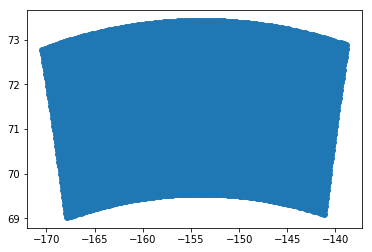

In [28]:
plt.scatter(lon, lat)

In [29]:
# Write as csv
df = pd.DataFrame.from_dict({'lat': lat.flatten(), 'lon': lon.flatten()})
df.to_csv('../../outputs/OSRA/rpg-by-ship-type/release-point-grid.csv', header=None, index=None)

In [30]:
ds = np.loadtxt('../../outputs/OSRA/rpg-by-ship-type/release-point-grid.csv', delimiter=',')

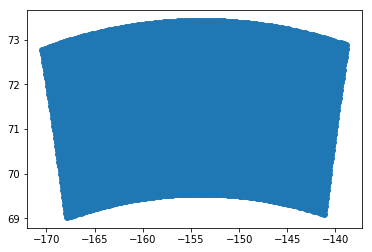

In [31]:
plt.scatter(ds[:, 1], ds[:, 0])

# Check positions of last rpg

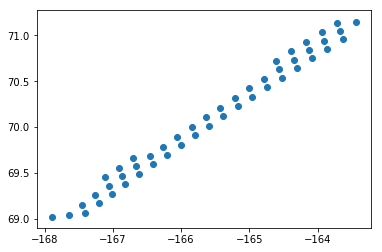

In [32]:
ds = np.loadtxt(fname, delimiter=',')
plt.scatter(ds[:, 1], ds[:, 0])